In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = {} # (prot, grid) -> ligand ->  np.array(N, 2) (rmsds, gscores)
with open('../combind_sherlock/bpp_outputs/glide_performance_expanded.tsv') as fp:
    for line in fp:
        try:
            (protein, grid, ligand, rmsds, gscores, emodels,
             inplace_gscore, inplace_emodel, inplace_rmsd) = line.strip().split('\t')
            inplace_gscore = float(inplace_gscore)
            inplace_emodel = float(inplace_emodel)
            inplace_rmsd = float(inplace_rmsd)
            rmsds = map(float, rmsds.split(','))
            gscores = map(float, gscores.split(','))
            emodels = map(float, emodels.split(','))
            assert len(rmsds) == len(gscores)
            key = (protein, grid)
            if key not in data: data[key] = {}
            assert ligand not in data[key]
            data[key][ligand] = (np.vstack([rmsds, gscores, emodels]),
                                 inplace_gscore, inplace_emodel, inplace_rmsd)
        except:
            print line.strip().split()[:3]

['ERA', '1A52', '1L2I_lig']
['P00734', '1A4W', '1SB1_lig']
['Q16539', '1KV1', '3GCP_lig']


In [3]:
print len(data)
print sum([len(v) for k, v in data.items()])
for count, key in sorted([(len(v), k) for k, v in data.items()]):
    print count, key[0]

36
661
2 5HT2B
2 M3
2 SIGMA1
2 TRPV1
3 GLUT1
5 MGLUR5
5 SMO
5 STRANSP
8 B2AR
9 DTRANSP
12 B1AR
12 PLK1
13 P24941
14 MR
14 P03951
15 AR
17 O60885
18 A2AR
19 GCR
24 P00489
24 Q16539
24 Q9Y233
28 CHK1
28 P00749
29 CDK2
29 ERA
29 MEK1
29 P00734
30 BRAF
30 JAK2
30 P00742
30 P00760
30 P07900
30 P18031
30 P56817
30 VITD


# Percentage with minimized pose

In [4]:
inplace = [(g, rmsds[0].min())
           for (prot, grid), ligands in data.items()
           for ligand, (rmsds, g, e, r) in ligands.items()
           if ligand.split('_')[0] != grid]
inplace = np.array(inplace)
print inplace.shape
print sum(inplace[:, 0] != float('inf')) / float(len(inplace))

(627, 2)
0.822966507177


In [5]:
# What is going on in the 20 cases where we can't get a minimized pose?
print 'No inplace, no native', sum(inplace[inplace[:, 0] == float('inf'), 1] > 2)
print 'No inplace, native', sum(inplace[inplace[:, 0] == float('inf'), 1] <= 2)
print 'Inplace, no native', sum(inplace[inplace[:, 0] != float('inf'), 1] > 2)
print 'Inplace, native', sum(inplace[inplace[:, 0] != float('inf'), 1] <= 2)

No inplace, no native 100
No inplace, native 11
Inplace, no native 85
Inplace, native 431


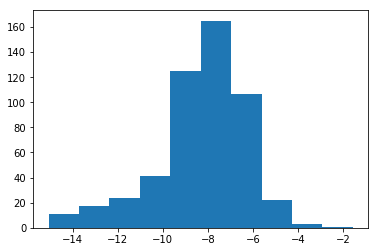

In [6]:
plt.hist(inplace[inplace[:, 0] != float('inf'), 0])
plt.show()

# Number of poses per ligand

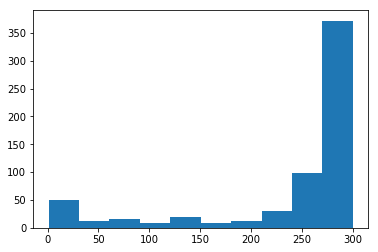

In [7]:
lengths = [rmsds.shape[1]
           for (prot, grid), ligands in data.items()
           for ligand, (rmsds, g, e, r) in ligands.items()
           if ligand.split('_')[0] != grid]

plt.hist(lengths)
plt.show()

# Glide performance for all ligands

In [8]:
def percentage_native(rmsds, poses = 1, thresh = 2.0):
    hit, total = 0.0, 0.0
    for rmsd in rmsds:
        if None in rmsd: continue
        hit   += any(rmsd[:poses] < thresh)
        total += 1
    return hit / total

class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            d = str(d)[:width-1]
            s += str(d).ljust(width, ' ')
        print s

def performance(rmsds):
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]

    POSE = [0, 1, 3, 10, 30, 100, 300]
    THRESH = [1, 1.5, 2, 2.5, 3, 3.5, 4, 8]

    for thresh in THRESH:
        Y = [percentage_native(rmsds, poses, thresh)
             for poses in POSE]
        plt.plot(Y, label = "< {} rmsd".format(thresh))
    plt.xticks(range(len(POSE)),POSE)
    plt.legend(loc = 4)
    plt.ylabel('Fraction Correct')
    plt.xlabel('Number of Poses Considered')
    plt.title('All Proteins')
    plt.ylim(0, 1)
    plt.xlim(0, len(POSE)-1)
    plt.show()

    # Table
    potential = Table([10]*4)
    potential(['RMSD', 'top 1', 'top 100', 'Potential'])

    for thresh in THRESH:
        potential([thresh,
                   percentage_native(rmsds, 1, thresh),
                   percentage_native(rmsds, 100, thresh), 
                   percentage_native(rmsds, 100, thresh) - percentage_native(rmsds, 1, thresh)
                  ])

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


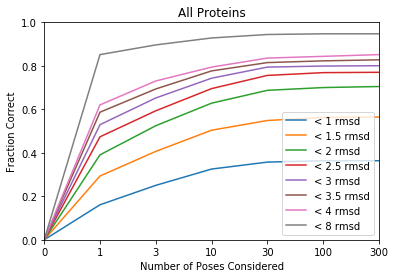

RMSD      top 1     top 100   Potential 
1         0.1610845 0.3636363 0.2025518 
1.5       0.2934609 0.5629984 0.2695374 
2         0.3907496 0.7001594 0.3094098 
2.5       0.4736842 0.7687400 0.2950558 
3         0.5295055 0.7990430 0.2695374 
3.5       0.5869218 0.8229665 0.2360446 
4         0.6204146 0.8437001 0.2232854 
8         0.8516746 0.9473684 0.0956937 


In [9]:
rmsds = [rmsds[[0, 1]]
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


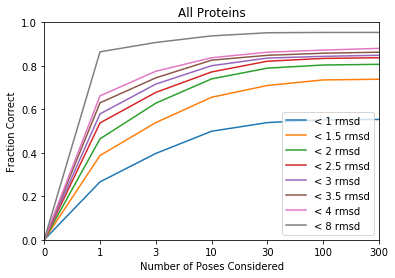

RMSD      top 1     top 100   Potential 
1         0.2663476 0.5518341 0.2854864 
1.5       0.3875598 0.7352472 0.3476874 
2         0.4641148 0.8038277 0.3397129 
2.5       0.5374800 0.8341307 0.2966507 
3         0.5789473 0.8437001 0.2647527 
3.5       0.6299840 0.8580542 0.2280701 
4         0.6618819 0.8724082 0.2105263 
8         0.8644338 0.9537480 0.0893141 


In [10]:
rmsds = [np.hstack([rmsds[[0, 1]], np.array([r, g]).reshape(2, 1)])
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


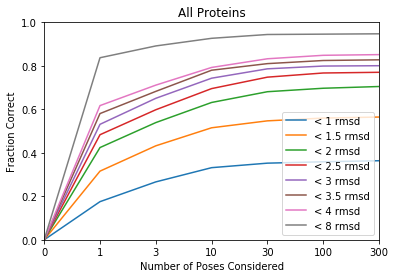

RMSD      top 1     top 100   Potential 
1         0.1754385 0.3588516 0.1834130 
1.5       0.3157894 0.5598086 0.2440191 
2         0.4242424 0.6969696 0.2727272 
2.5       0.4832535 0.7671451 0.2838915 
3         0.5311004 0.7990430 0.2679425 
3.5       0.5805422 0.8245614 0.2440191 
4         0.6172248 0.8484848 0.2312599 
8         0.8373205 0.9457735 0.1084529 


In [11]:
rmsds = [rmsds[[0, 2]]
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


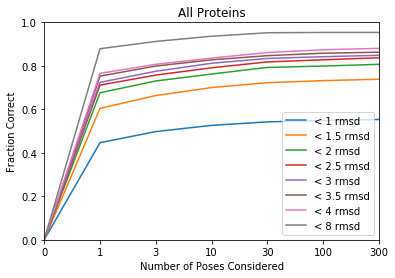

RMSD      top 1     top 100   Potential 
1         0.4465709 0.5486443 0.1020733 
1.5       0.6044657 0.7320574 0.1275917 
2         0.6762360 0.7990430 0.1228070 
2.5       0.7113237 0.8277511 0.1164274 
3         0.7240829 0.8421052 0.1180223 
3.5       0.7527910 0.8580542 0.1052631 
4         0.7655502 0.8740031 0.1084529 
8         0.8787878 0.9537480 0.0749601 


In [12]:
# Note: Emodel scores are comparable across docking runs, so this is not a fair comparison..
rmsds = [np.hstack([rmsds[[0, 2]], np.array([r, e]).reshape(2, 1)])
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
performance(rmsds)

# Glide performance averaged over targets

In [13]:
def target_performance(top1, top100, labels):
    print 'Top pose is correct', sum(top1) / float(len(top1))
    print 'Top 100 has one correct', sum(top100) / float(len(top100))

    markers = ['o', 'v', 'x', 's']
    f, ax = plt.subplots()
    for i, (_x, _y, _label) in enumerate(zip(top1, top100, labels)):
        plt.scatter(_x, _y, marker = markers[i/10], label = _label)
    plt.xlabel('Top 1', fontsize = 16)
    plt.ylabel('Top 100', fontsize = 16)
    plt.plot(range(2), linestyle='--', c = 'k')
    plt.title('Fraction Near-Native', fontsize = 20)
    ax.set_aspect('equal', 'box')
    plt.legend(bbox_to_anchor=(1.1, 1.05), ncol=2)
    plt.show()

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.357387661383
Top 100 has one correct 0.722992781225


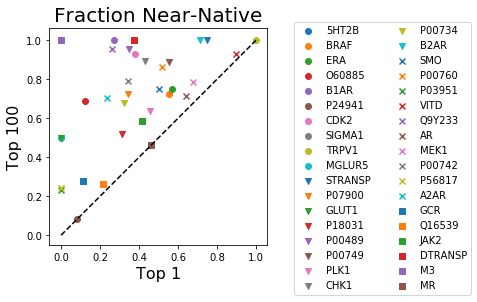

In [14]:
# GScore
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [rmsds[[0, 1]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.277370803621
Top 100 has one correct 0.608376471135


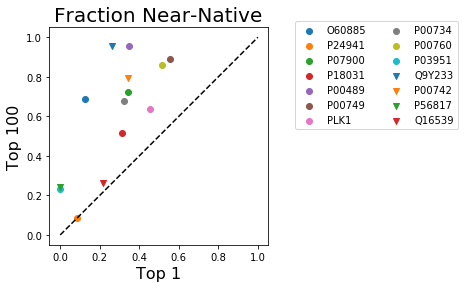

In [15]:
# GScore, only PDBbind
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    if prot[0] not in ['P', 'Q', 'O']: continue
    if prot == 'PLK': continue
    rmsds = [rmsds[[0, 1]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.410109297428
Top 100 has one correct 0.802690310862


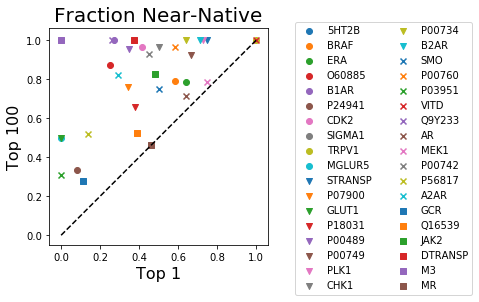

In [16]:
# GScore + in place
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [np.hstack([rmsds[[0, 1]], np.array([r, g]).reshape(2, 1)])
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.471010618823
Top 100 has one correct 0.719833274669


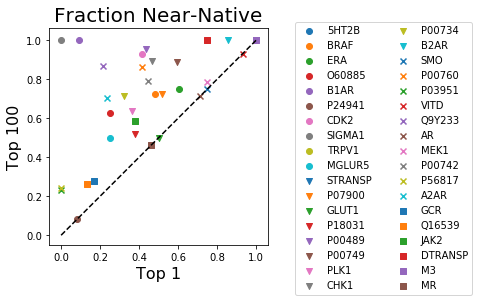

In [17]:
# Emodel
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [rmsds[[0, 2]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.29658716045
Top 100 has one correct 0.600252025704


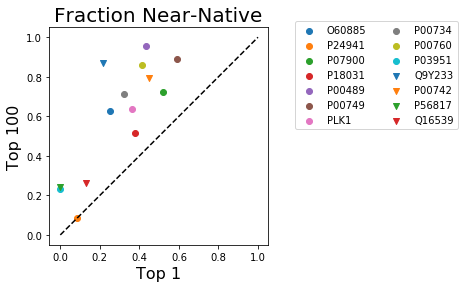

In [18]:
# Emodel, only PDBbind
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    if prot[0] not in ['P', 'Q', 'O']: continue
    if prot == 'PLK': continue
    rmsds = [rmsds[[0, 2]]
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Top pose is correct 0.706853475395
Top 100 has one correct 0.799316997519


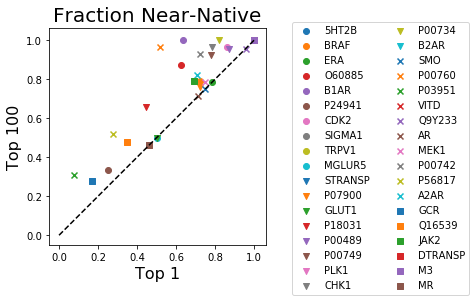

In [19]:
# Emodel + in place
# Note: Emodel scores are comparable across docking runs, so this is not a fair comparison..
top1, top100, labels = [], [], []
for (prot, grid), ligands in data.items():
    rmsds = [np.hstack([rmsds[[0, 2]], np.array([r, e]).reshape(2, 1)])
             for ligand, (rmsds, g, e, r) in ligands.items()
             if ligand.split('_')[0] != grid]
    rmsds = [np.vstack(sorted(rmsd.T, key = lambda x: x[1]))[:, 0] for rmsd in rmsds]
    top1 += [percentage_native(rmsds, 1, 2.0)]
    top100 += [percentage_native(rmsds, 100, 2.0)]
    labels += [prot]
target_performance(top1, top100, labels)

# Correlations between glide scores and correctness

In [20]:
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr, spearmanr, ranksums

def plot(rmsds, xlabel, xlim = None):
    # RMSDs
    
    plt.scatter(rmsds[:, 1], rmsds[:, 0], s = 1, alpha = 0.02)
    plt.ylabel(r'RMSD ($\AA$)', fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylim(0)
    if xlim is not None: plt.xlim(*xlim)
    plt.show()
    
    print 'Pearson', pearsonr(rmsds[:, 1], rmsds[:, 0])
    print spearmanr(rmsds[:, 1], rmsds[:, 0])

    # Q-Q plot
    quants = 500
    scores = np.vstack(sorted(rmsds, key = lambda x: x[1]))
    scores[:, 0] = scores[:, 0] < 2
    bin_size = scores.shape[0] / quants
    x, y = [], []
    for i in range(0, scores.shape[0], bin_size):
        x += [scores[i:i+bin_size, 1].mean()]
        y += [np.log(scores[i:i+bin_size, 0].mean())]

    plt.scatter(x, y, s = 10, alpha = 0.4)
    plt.ylabel('Log Probability Near-Native', fontsize = 16)
    plt.xlabel(xlabel, fontsize = 16)
    if xlim is not None: plt.xlim(*xlim)
    plt.show()
    
    print ranksums(scores[scores[:, 0] == 0, 1], scores[scores[:, 0] == 1, 1])

    # Density Plot
    kernel = KernelDensity(bandwidth = .1).fit(scores[:, 1].reshape(-1, 1))
    density = np.exp(kernel.score_samples(np.array(x).reshape(-1, 1)))
    
    plt.plot(x, density)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel('Frequency', fontsize = 16)
    if xlim is not None: plt.xlim(*xlim)
    plt.ylim(0)
    plt.show()

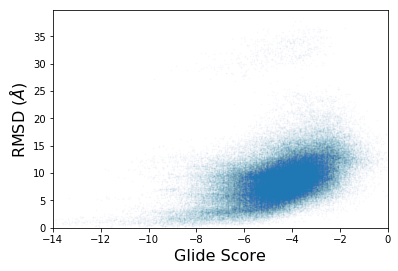

Pearson (0.46491431898713387, 0.0)
SpearmanrResult(correlation=0.48721291174987819, pvalue=0.0)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


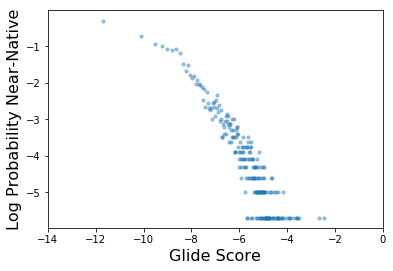

RanksumsResult(statistic=78.719895848011532, pvalue=0.0)


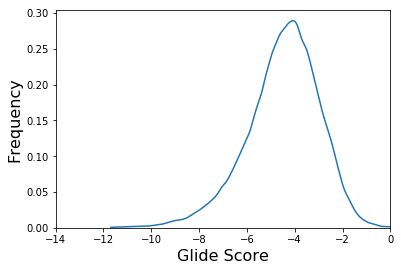

In [21]:
rmsds = np.hstack([rmsd[[0, 1]]
                   for (prot, grid), ligands in data.items()
                   for ligand, (rmsd, g, e, r) in ligands.items()
                   if ligand.split('_')[0] != grid]).T
plot(rmsds, 'Glide Score', (-14, 0))

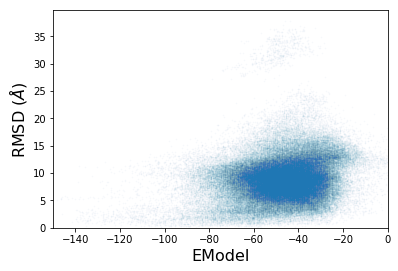

Pearson (0.20980835885854487, 0.0)
SpearmanrResult(correlation=0.18690755473674861, pvalue=0.0)

/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


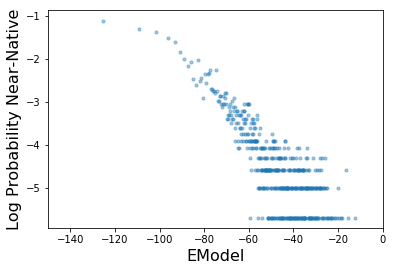

RanksumsResult(statistic=50.813475525362279, pvalue=0.0)


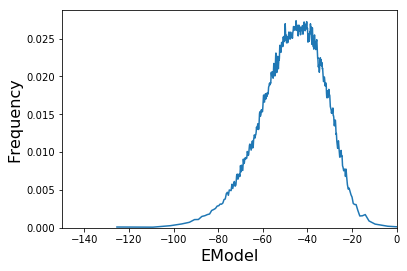

In [22]:
rmsds = np.hstack([rmsd[[0, 2]]
                   for (prot, grid), ligands in data.items()
                   for ligand, (rmsd, g, e, r) in ligands.items()
                   if ligand.split('_')[0] != grid]).T
plot(rmsds, 'EModel', (-150, 0))

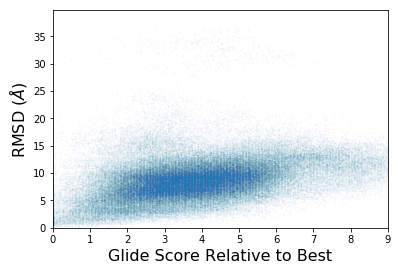

Pearson (0.37990601757925063, 0.0)
SpearmanrResult(correlation=0.41825756674354564, pvalue=0.0)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


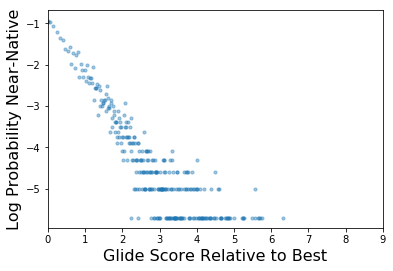

RanksumsResult(statistic=72.941287479435033, pvalue=0.0)


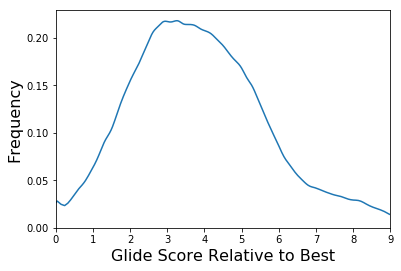

In [23]:
rmsds = []
for (prot, grid), ligands in data.items():
    for ligand, (rmsd, g, e, r) in ligands.items():
        if ligand.split('_')[0] != grid:
            rmsds += [rmsd[[0, 1]].copy()]
            rmsds[-1][1, :] -= rmsds[-1][1, 0]
rmsds = np.hstack(rmsds).T

plot(rmsds, 'Glide Score Relative to Best', (0, 9))

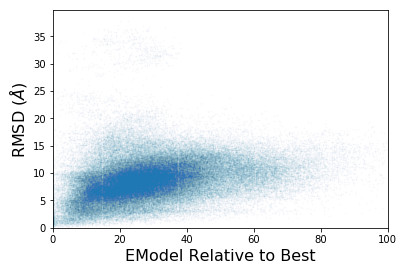

Pearson (0.2960639701209512, 0.0)
SpearmanrResult(correlation=0.37148478711899857, pvalue=0.0)


/Users/jpaggi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log


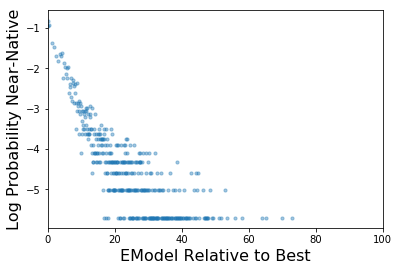

RanksumsResult(statistic=63.889273777290946, pvalue=0.0)


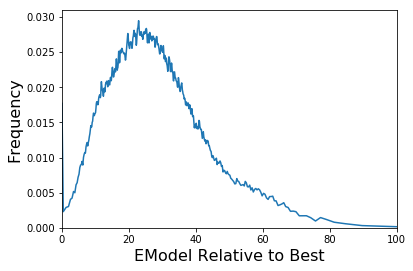

In [24]:
rmsds = []
for (prot, grid), ligands in data.items():
    for ligand, (rmsd, g, e, r) in ligands.items():
        if ligand.split('_')[0] != grid:
            rmsds += [rmsd[[0, 2]].copy()]
            rmsds[-1][1, :] -= rmsds[-1][1, :].min()
rmsds = np.hstack(rmsds).T

plot(rmsds, 'EModel Relative to Best', (0, 100))

# Direct compare EModel to GScore

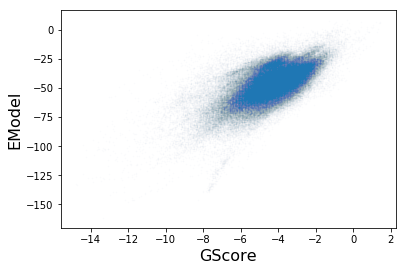

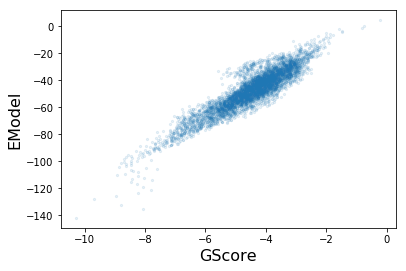

In [25]:
rmsds = [rmsds[[1, 2]]
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
rmsds = np.hstack(rmsds)
plt.scatter(rmsds[0], rmsds[1], s = 1, alpha = 0.01)
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.show()

quants = 5000
scores = np.vstack(sorted(rmsds.T, key = lambda x: x[1]))
bin_size = scores.shape[0] / quants
x, y = [], []
for i in range(0, scores.shape[0], bin_size):
    x += [scores[i:i+bin_size, 0].mean()]
    y += [scores[i:i+bin_size, 1].mean()]
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.scatter(x, y, s = 5, alpha = 0.1)
plt.show()

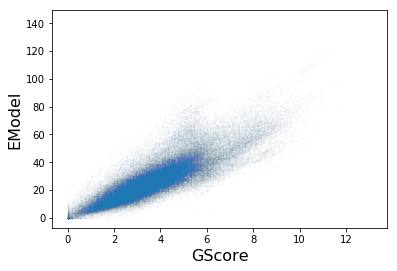

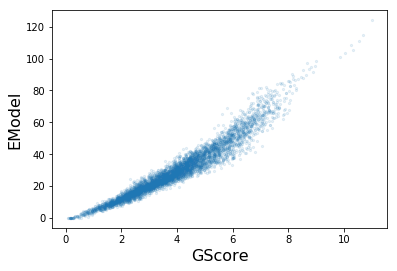

In [26]:
rmsds = [rmsds[[1, 2]] - rmsds[[1, 2]].min(axis = 1).reshape(2, 1)
         for (prot, grid), ligands in data.items()
         for ligand, (rmsds, g, e, r) in ligands.items()
         if ligand.split('_')[0] != grid]
rmsds = np.hstack(rmsds)
plt.scatter(rmsds[0], rmsds[1], s = 1, alpha = 0.01)
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.show()

quants = 5000
scores = np.vstack(sorted(rmsds.T, key = lambda x: x[1]))
bin_size = scores.shape[0] / quants
x, y = [], []
for i in range(0, scores.shape[0], bin_size):
    x += [scores[i:i+bin_size, 0].mean()]
    y += [scores[i:i+bin_size, 1].mean()]
plt.ylabel('EModel', fontsize = 16)
plt.xlabel('GScore', fontsize = 16)
plt.scatter(x, y, s = 5, alpha = 0.1)
plt.show()